Individual assignment
===
1. Preprocessing
2. Sanity checks
3. First-level analysis

# 0. Setup

## Imports

In [1]:
import os
from os.path import join as opj
import json
from nipype.interfaces.fsl import (
    BET,
    ExtractROI,
    FAST,
    FLIRT,
    ImageMaths,
    MCFLIRT,
    SliceTimer,
    Threshold,
    IsotropicSmooth,
)

# from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node
from IPython.display import Image

# Check if ENV variables are set
print(os.environ["FSLDIR"])
print(os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]

# os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

/opt/fsl-5.0.11
NIFTI_GZ


## Download data and MNI atlas

In [2]:
# !gdown 1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
# !unzip ./ds000102.zip -d ./data

# add mni template to fsl dir
# os.makedirs(fslpath + "/data/standard", exist_ok=True)
# !wget 'https://ucloud.univie.ac.at/index.php/s/bnj6HPWqImlpFjD/download' -O mniatlas.zip
# !unzip -oq mniatlas.zip -d ${FSLDIR}/data/standard

## Experiment parameters

In [3]:
project_root_dir = os.getcwd()
experiment_dir = project_root_dir + "/output"
output_dir = "datasink"
working_dir = "workingdir"
data_dir = project_root_dir + "/data/ds000102"

# list of subject identifiers
subject_list = ["02"]

# list of session identifiers
task_list = ["flanker"]

# Smoothing widths to apply
fwhm = [4]  # [4, 8]

# TR of functional images
with open(data_dir + "/task-flanker_bold.json", "rt") as fp:
    task_info = json.load(fp)
TR = task_info["RepetitionTime"]

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4


os.environ["FSLOUTPUTTYPE"] = "NIFTI"

os.makedirs("data", exist_ok=True)
os.makedirs("output/working_dir", exist_ok=True)
os.makedirs(fslpath + "/data/standard", exist_ok=True)

# 1. Preprocessing

## Remove the first 4 volumes

In [34]:
#
#
#

## Specify Nodes for the main workflow¶

In [4]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type="NIFTI"), name="extract")

# MCFLIRT - motion correction
mcflirt = Node(
    MCFLIRT(mean_vol=True, save_plots=True, output_type="NIFTI"), name="mcflirt"
)

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(
    SliceTimer(
        index_dir=False, interleaved=True, output_type="NIFTI", time_repetition=TR
    ),
    name="slicetimer",
)

# Smooth - image smoothing
smooth = Node(IsotropicSmooth(), name="smooth")
#smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(
    ArtifactDetect(
        norm_threshold=2,
        zintensity_threshold=3,
        mask_type="spm_global",
        parameter_source="FSL",
        use_differences=[True, False],
        plot_type="svg",
    ),
    name="art",
)

## Coregistration Workflow¶

In [5]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5, robust=True, output_type="NIFTI_GZ"), name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type="NIFTI_GZ"), name="segmentation")

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]


# Threshold - Threshold WM probability image
threshold = Node(
    Threshold(thresh=0.5, args="-bin", output_type="NIFTI_GZ"), name="threshold"
)

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type="NIFTI_GZ"), name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(
    FLIRT(
        dof=6,
        cost="bbr",
        schedule=opj(os.getenv("FSLDIR"), "etc/flirtsch/bbr.sch"),
        output_type="NIFTI_GZ",
    ),
    name="coreg_bbr",
)

# Apply coregistration warp to functional images
applywarp = Node(
    FLIRT(interp="spline", apply_isoxfm=iso_size, output_type="NIFTI"), name="applywarp"
)

# Apply coregistration warp to mean file
applywarp_mean = Node(
    FLIRT(interp="spline", apply_isoxfm=iso_size, output_type="NIFTI_GZ"),
    name="applywarp_mean",
)

# Create a coregistration workflow
coregwf = Workflow(name="coregwf")
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect(
    [
        (bet_anat, segmentation, [("out_file", "in_files")]),
        (segmentation, threshold, [(("partial_volume_files", get_wm), "in_file")]),
        (bet_anat, coreg_pre, [("out_file", "reference")]),
        (threshold, coreg_bbr, [("out_file", "wm_seg")]),
        (coreg_pre, coreg_bbr, [("out_matrix_file", "in_matrix_file")]),
        (coreg_bbr, applywarp, [("out_matrix_file", "in_matrix_file")]),
        (bet_anat, applywarp, [("out_file", "reference")]),
        (coreg_bbr, applywarp_mean, [("out_matrix_file", "in_matrix_file")]),
        (bet_anat, applywarp_mean, [("out_file", "reference")]),
    ]
)

## Specify input & output stream¶

In [6]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(
    IdentityInterface(fields=["subject_id", "task_name"]), name="infosource"
)
infosource.iterables = [("subject_id", subject_list), ("task_name", task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj(
    "sub-{subject_id}",
    "anat",
    "sub-{subject_id}_T1w.nii.gz",
)
func_file = opj(
    "sub-{subject_id}",
    "func",
    "sub-{subject_id}_task-{task_name}_run-1_bold.nii.gz",
)

templates = {"anat": anat_file, "func": func_file}
selectfiles = Node(SelectFiles(templates, base_directory=data_dir), name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(
    DataSink(base_directory=experiment_dir, container=output_dir), name="datasink"
)

## Use the following DataSink output substitutions
substitutions = [
    ("_subject_id_", "sub-"),
    ("_task_name_", "/task-"),
    ("_fwhm_", "fwhm-"),
    ("_roi", ""),
    ("_mcf", ""),
    ("_st", ""),
    ("_flirt", ""),
    (".nii_mean_reg", "_mean"),
    (".nii.par", ".par"),
]
subjFolders = [("fwhm-%s/" % f, "fwhm-%s_" % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow¶

In [9]:
# Create a preprocessing workflow
preproc = Workflow(name="preproc")
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect(
    [
        (
            infosource,
            selectfiles,
            [("subject_id", "subject_id"), ("task_name", "task_name")],
        ),
        (selectfiles, extract, [("func", "in_file")]),
        (extract, mcflirt, [("roi_file", "in_file")]),
        (mcflirt, slicetimer, [("out_file", "in_file")]),
        (
            selectfiles,
            coregwf,
            [("anat", "bet_anat.in_file"), ("anat", "coreg_bbr.reference")],
        ),
        (
            mcflirt,
            coregwf,
            [
                ("mean_img", "coreg_pre.in_file"),
                ("mean_img", "coreg_bbr.in_file"),
                ("mean_img", "applywarp_mean.in_file"),
            ],
        ),
        (slicetimer, coregwf, [("slice_time_corrected_file", "applywarp.in_file")]),
    #    (coregwf, smooth, [("applywarp.out_file", "in_files")]), # SPM
        (coregwf, smooth, [("applywarp.out_file", "in_file")]), # SPM
        (mcflirt, datasink, [("par_file", "preproc.@par")]),
    #    (smooth, datasink, [("smoothed_files", "preproc.@smooth")]), # SPM
        (smooth, datasink, [("out_file", "preproc.@smooth")]),
        (coregwf, datasink, [("applywarp_mean.out_file", "preproc.@mean")]),
        (coregwf, art, [("applywarp.out_file", "realigned_files")]),
        (mcflirt, art, [("par_file", "realignment_parameters")]),
        (
            coregwf,
            datasink,
            [
                ("coreg_bbr.out_matrix_file", "preproc.@mat_file"),
                ("bet_anat.out_file", "preproc.@brain"),
            ],
        ),
        (
            art,
            datasink,
            [
                ("outlier_files", "preproc.@outlier_files"),
                ("plot_files", "preproc.@plot_files"),
            ],
        ),
    ]
)

## Visualize the workflow¶

221204-11:35:16,720 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


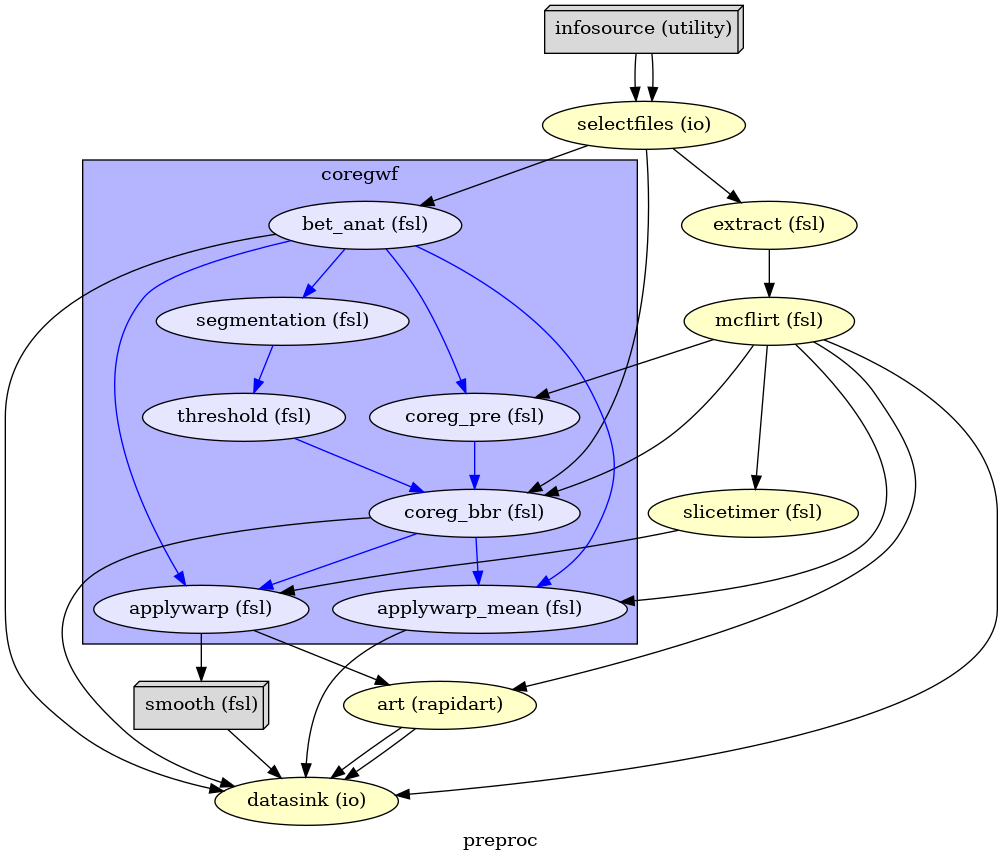

In [10]:
# Create preproc output graph
preproc.write_graph(graph2use="colored", format="png", simple_form=True)

Image(filename=opj(preproc.base_dir, "preproc", "graph.png"))

221204-11:35:20,323 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


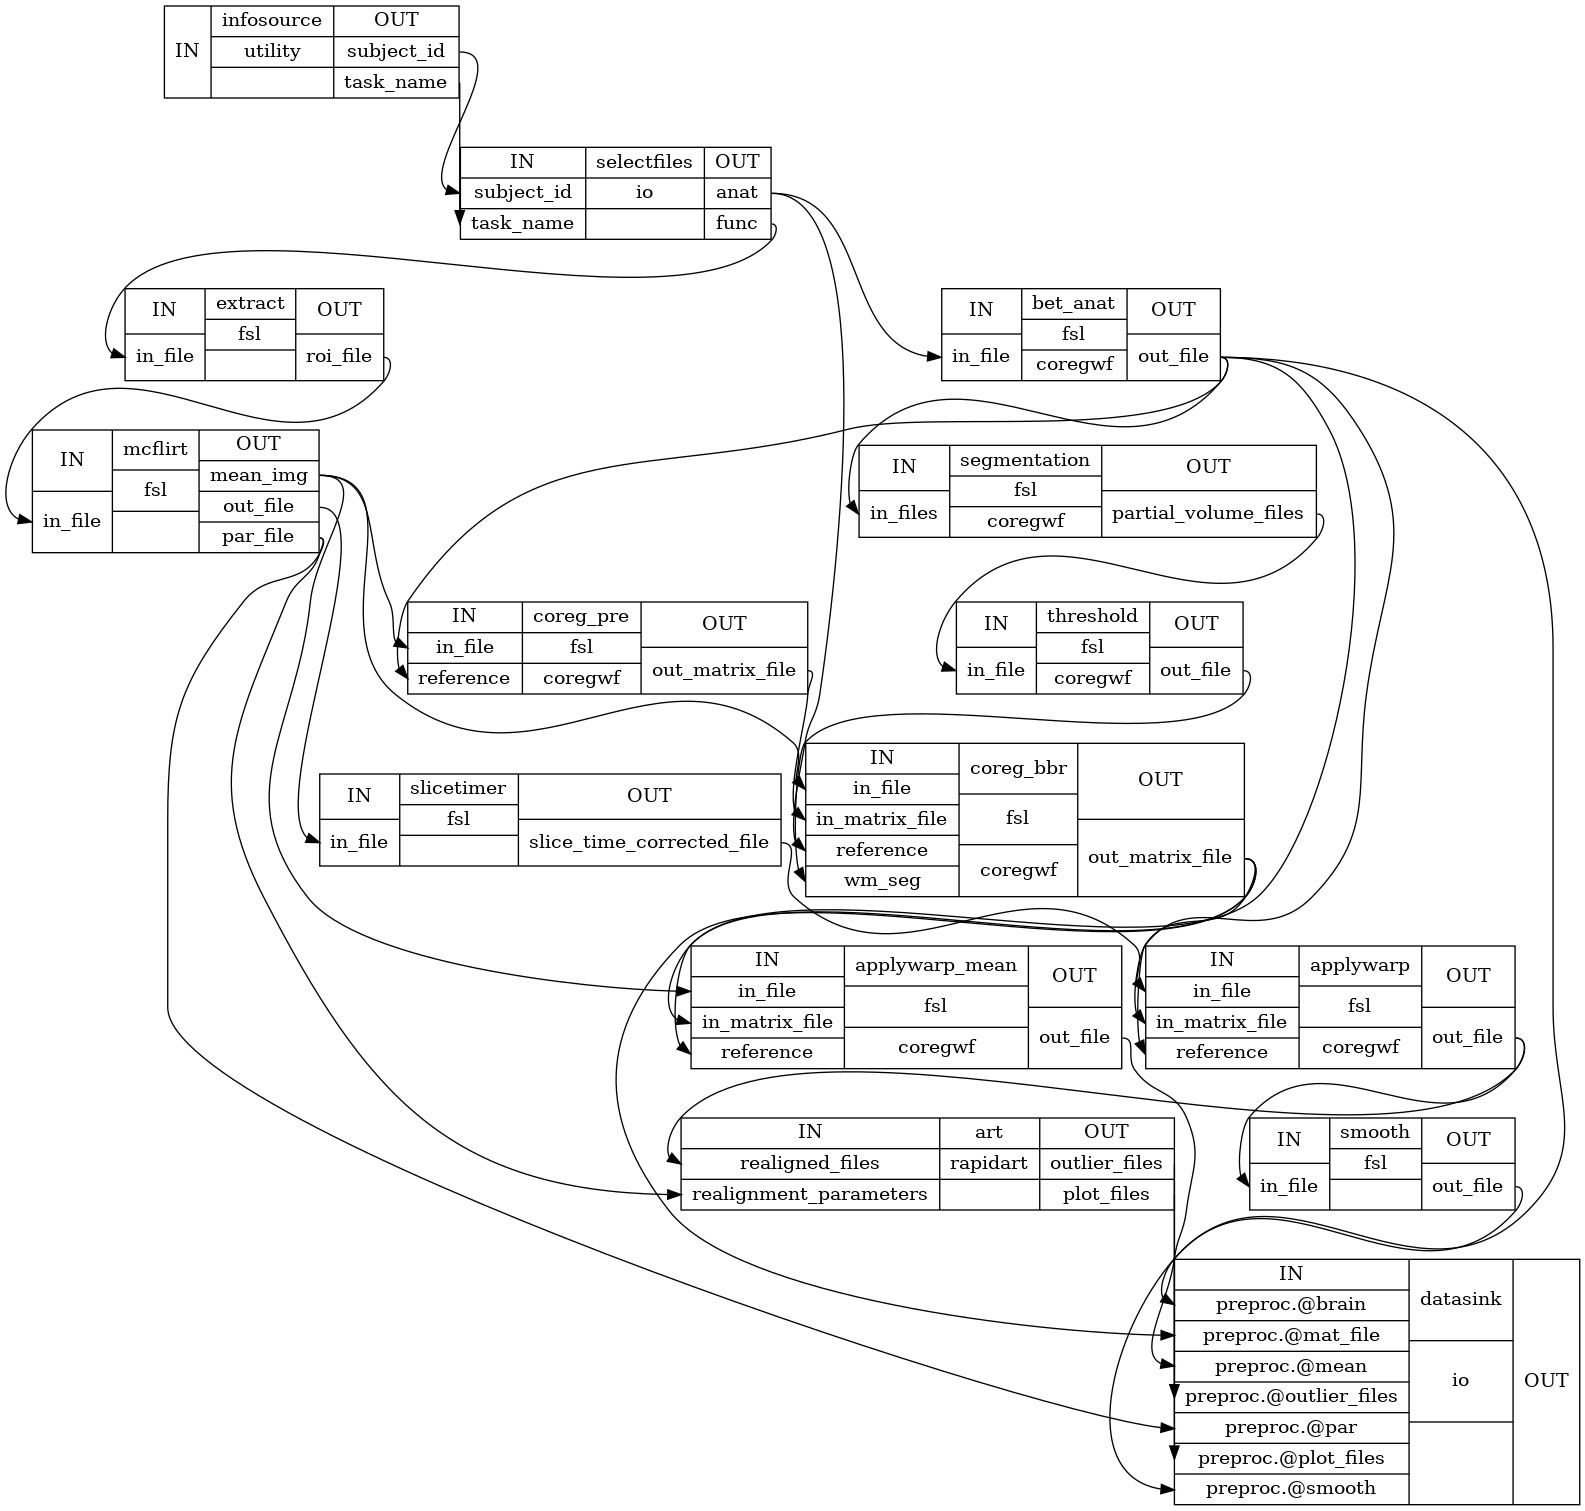

In [11]:
# Visualize the detailed graph
preproc.write_graph(graph2use="flat", format="png", simple_form=True)
Image(filename=opj(preproc.base_dir, "preproc", "graph_detailed.png"))

## Run the Workflow¶

In [12]:
preproc.run('MultiProc', plugin_args={'n_procs': 8})

221204-11:36:01,192 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
221204-11:36:01,220 nipype.workflow INFO:
	 Running in parallel.
221204-11:36:01,336 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.
221204-11:36:01,474 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/work/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/selectfiles".
221204-11:36:01,481 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
221204-11:36:01,487 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001692s.
221204-11:36:03,342 nipype.workflow INFO:
	 [Job 0] Completed (preproc.selectfiles).
221204-11:36:03,354 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.
221204-11:36:03,455 nipype.workflow INFO:
	 [Job 1] Cac

## Inspect output¶

In [19]:
!tree output/datasink/preproc

output/datasink/preproc
└── sub-02
    └── task-flanker
        ├── art.sub-02_task-flanker_run-1_bold_outliers.txt
        ├── fwhm-4_sub-02_task-flanker_run-1_bold_smooth.nii
        ├── plot.sub-02_task-flanker_run-1_bold.svg
        ├── sub-02_T1w_brain.nii.gz
        ├── sub-02_task-flanker_run-1_bold.par
        ├── sub-02_task-flanker_run-1_bold_mean.mat
        └── sub-02_task-flanker_run-1_bold_mean.nii.gz

2 directories, 7 files


## Visualize results¶

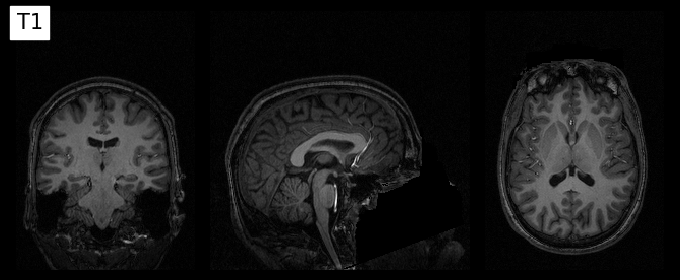

In [22]:
from nilearn import image, plotting
%matplotlib inline 
out_path = 'output/datasink/preproc/sub-02/task-flanker'

plotting.plot_epi(
    'data/ds000102/sub-02/anat/sub-02_T1w.nii.gz',
    title="T1", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

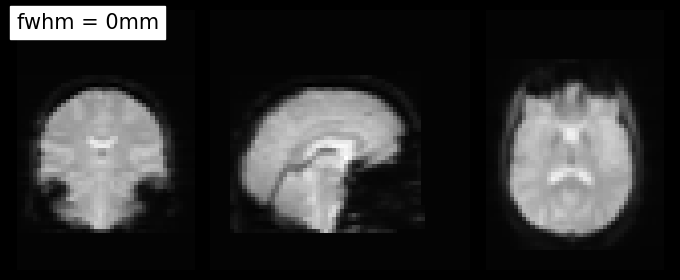

In [24]:
plotting.plot_epi(opj(out_path, 'sub-02_task-flanker_run-1_bold_mean.nii.gz'),
                  title="fwhm = 0mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

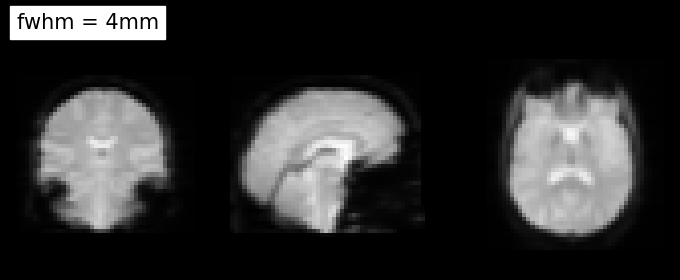

In [ ]:
plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-4_sub-02_task-flanker_run-1_bold_smooth.nii')),
                  title="fwhm = 4mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

Inspect motion

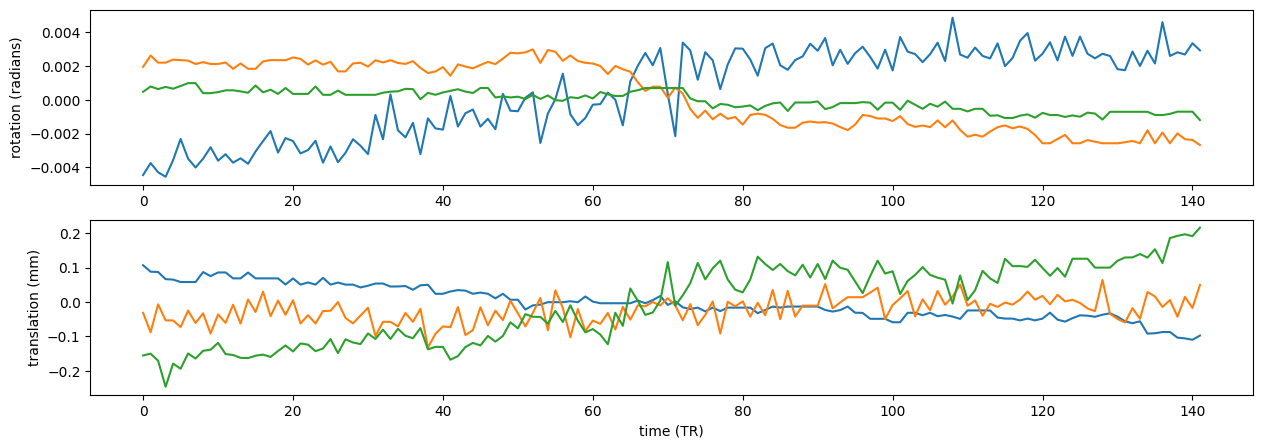

In [31]:
import numpy as np
import matplotlib.pyplot as plt
par = np.loadtxt('output/datasink/preproc/sub-02/task-flanker/sub-02_task-flanker_run-1_bold.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)');

<div class="alert alert-info">Seems to be an outlier at around volume 75 on the x-axis (rotation)</div>

Outliers were detected at volumes: [0. 1. 2. 3.]


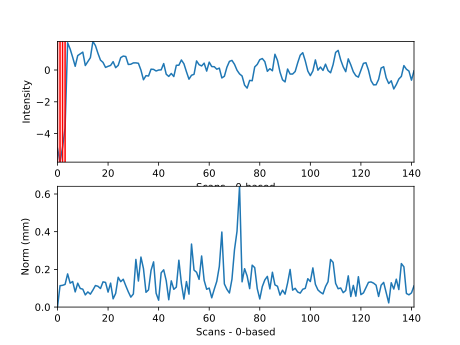

In [30]:
outlier_ids = np.loadtxt('output/datasink/preproc/sub-02/task-flanker/art.sub-02_task-flanker_run-1_bold_outliers.txt')
print('Outliers were detected at volumes: %s' % outlier_ids)

from IPython.display import SVG
SVG(filename='output/datasink/preproc/sub-02/task-flanker/plot.sub-02_task-flanker_run-1_bold.svg')

# 2. Sanity checks

In [32]:
#
#
#

# 3. First Level Analysis

In [33]:
#
#
#